In [38]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import time
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 9]

## data monthly wage

In [39]:
data_wage = pd.read_csv("./data/monthly-wage.csv", sep=";")

In [40]:
data_wage.Month = data_wage.Month.apply(lambda x: datetime.strptime(x, "%Y-%m"))

## data energy consumption

In [41]:
data_energy = pd.read_csv("./data/energy_consump.csv")

In [42]:
data_energy.Date = data_energy.Date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

## data price of currency 

In [43]:
data_price = pd.read_csv("./data/price_data.csv")

In [44]:
data_price["datetime"] = data_price.timestamp.apply(lambda x: datetime.fromtimestamp(x))

In [45]:
class SES:
    def __init__(self, alpha=0.3):
        self.alpha = alpha
    
    def smooth(self, data):
        smoothed_data = []
        for index, datum in enumerate(data):
            if index == 0: l = datum
            l = self.alpha * datum + (1-self.alpha) * l
            smoothed_data.append(l)
        return smoothed_data

In [46]:
class DES:
    def __init__(self, alpha=0.3, gamma = 0.4):
        self.alpha = alpha
        self.gamma = gamma
    
    def smooth(self, data):
        level = data[0]
        trend = data[1] - data[0]
        self.pred = np.zeros(len(data))
        
        for i in range(1, len(data)):
            level_p = self.alpha * data[i] + (1 - self.alpha)*(level + trend)
            trend = self.gamma * (level_p - level) + (1 - self.gamma) * trend
            level = level_p
            self.pred[i] = level
            
        self.level = level
        self.trend = trend
        return self.pred
    
    def predict(self):
        pred_new = self.level + self.trend
        np.append(self.pred, pred_new)
        return self.pred

In [47]:
class HWM:
    def __init__(self, season_amount, n_step, alpha=0.3, beta = 0.5, gamma = 0.4):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_step = n_step
        self.L = season_amount
        
    def init_trend(self, data):
        '''
        Initializes the starter trend based 
        on average of trend averages across seasons.
        '''
        
        all_trend = 0
        for i in range(self.L):
            all_trend += (data[i+self.L] - data[i])/self.L
        return all_trend / self.L
    
    def init_seasonality(self, data):
        '''
        1. Get the average level of the seasons
        2. Divide observation by seasonal mean
        3. Average the numbers from the previous step based on amount of seasons
        '''
        seasonality = {}
        seasonal_mean = []
        n_seasons = int(len(data)/self.L)
        
        # Get the season means
        for s_i in range(n_seasons):
            seasonal_mean.append(sum(data[self.L*s_i:self.L*s_i+self.L])/self.L)

        # init values
        for i in range(self.L):
            sum_season = []
            for s_i in range(n_seasons):
                dat_compt = data[self.L*s_i+i]
                mean_compt = seasonal_mean[s_i]
                season_compt = dat_compt - mean_compt
                sum_season.append(season_compt)
            sum_season_all = np.sum(sum_season)
            seasonality[i] = sum_season_all/n_seasons
        return seasonality
        
    
    def smooth(self, data):
        pred = []
        seasonality = self.init_seasonality(data)
        for i in range(len(data) + self.n_step):
            #ruleset for initializing the values
            if i ==0:
                smoothened = data[0]
                trend = self.init_trend(data)
                pred.append(smoothened)
                
            #ruleset for forecasting
            elif i>=self.n_step:
                window = i-len(data)+1
                pred.append((smoothened + trend * window) 
                            + seasonality[i%self.L])
            
            #adapt the trends, seasonalities, etc.
            else:
                level = data[i]
                smoothened_p = smoothened

                smoothened = (self.alpha*(level - seasonality[i%self.L])
                              +(1-self.alpha)*(smoothened_p + trend))
                                          
                trend = (self.beta * (smoothened - smoothened_p) + 
                         (1-self.beta) * trend)
                
                seasonality[i%self.L] = (self.gamma*(level - smoothened) + 
                                        (1-self.gamma)* seasonality[i%self.L])
                
                pred.append(smoothened + trend + seasonality[i%self.L])
            
        return pred

In [48]:
data_eng = data_energy.EnergyConsump.values[:-10]
data_wg = data_wage["Real wage"].values
data_cur = data_price.price.values

In [49]:
ses = SES(0.1)
#the ones below can also predict
des = DES(0.1, 0.5)
hwm = HWM(season_amount = 365, n_step = 0, alpha=0.5, beta = 0.05, gamma = 0.99)

In [50]:
smoothed_data_ses_eng = ses.smooth(data_eng)
smoothed_data_des_eng = des.smooth(data_eng)
smoothed_data_hwm_eng = hwm.smooth(data_eng)

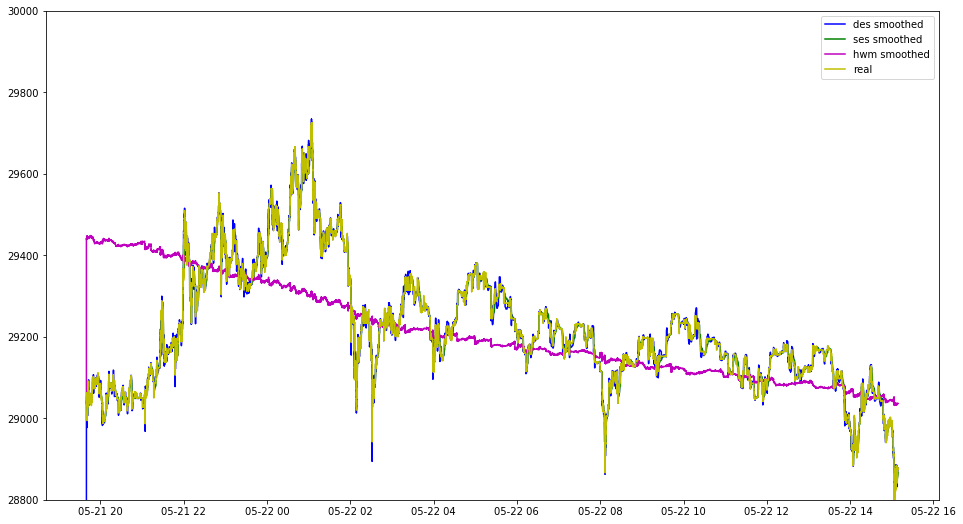

In [51]:
hwm = HWM(season_amount = 690, n_step = 0, alpha=0.5, beta = 0.05, gamma = 0.99)

smoothed_data_ses_cur = ses.smooth(data_cur)
smoothed_data_des_cur = des.smooth(data_cur)
smoothed_data_hwm_cur = hwm.smooth(data_cur)

plt.ylim((28800,30000))
plt.plot(data_price.datetime, smoothed_data_des_cur, "b", label="des smoothed")
plt.plot(data_price.datetime, smoothed_data_ses_cur, "g", label="ses smoothed")
plt.plot(data_price.datetime, smoothed_data_hwm_cur, "m", label="hwm smoothed")
plt.plot(data_price.datetime, data_cur, "y", label="real")
plt.legend()

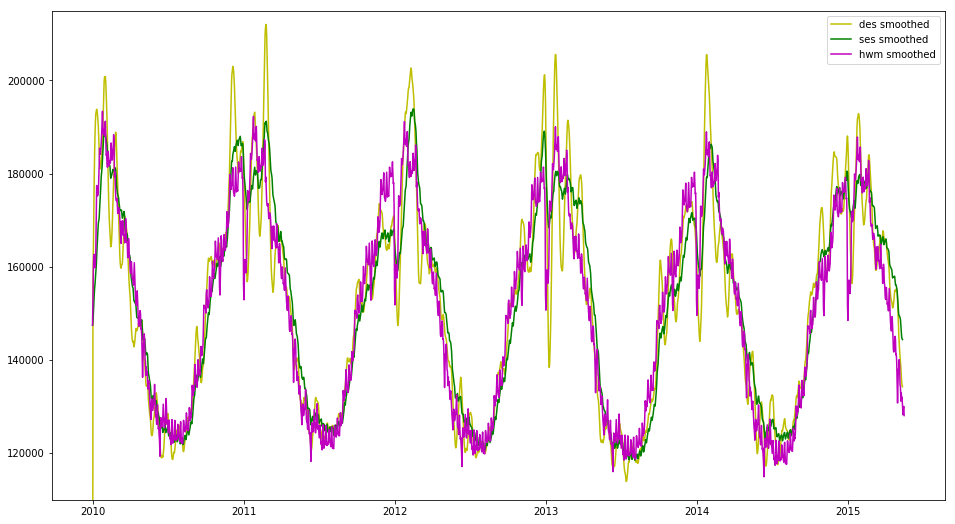

In [52]:
plt.ylim((110000,215000))
plt.plot(data_energy.Date[:-10], smoothed_data_des_eng, "y", label="des smoothed")
plt.plot(data_energy.Date[:-10], smoothed_data_ses_eng, "g", label="ses smoothed")
plt.plot(data_energy.Date[:-10], smoothed_data_hwm_eng, "m", label="hwm smoothed")
plt.legend()

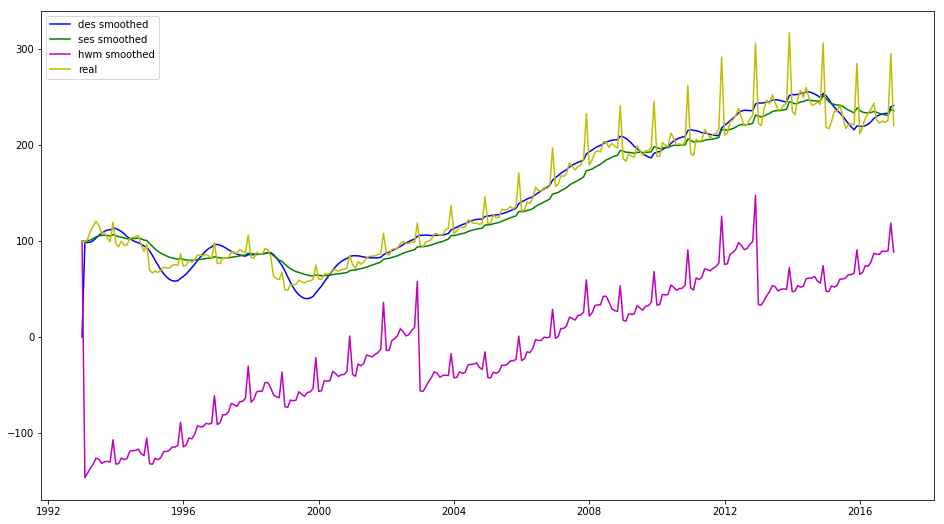

In [53]:
hwm2 = HWM(season_amount = 120, n_step = 0, alpha=0.8, beta = 0.3, gamma = 0.8)
smoothed_data_ses_wg = ses.smooth(data_wg)
smoothed_data_des_wg = des.smooth(data_wg)
smoothed_data_hwm_wg = hwm2.smooth(data_wg)

plt.plot(data_wage.Month, smoothed_data_des_wg, "b", label="des smoothed")
plt.plot(data_wage.Month, smoothed_data_ses_wg, "g", label="ses smoothed")
plt.plot(data_wage.Month, smoothed_data_hwm_wg, "m", label="hwm smoothed")
plt.plot(data_wage.Month, data_wg, "y", label="real")
plt.legend()